## Random Sort

This notebook implements the Random Sort algorithm, the theory is described in detail here: https://medium.com/@pete.b.condon/estimating-aggregate-variance-introducing-random-sort-b296da196788

Random Sort assumes that a model has already been created with a distribution of errors, or is Continuous as Categorical: https://medium.com/@pete.b.condon/residual-machine-learning-continuous-as-categorical-1c6fc11da7d8. We have created a toy Random Forest to meet this requirement based on fast.ai's libraries (https://github.com/fastai/fastai).

The data is from the Recruit Restaurant challenge, which can be found here: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data

# Set up

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

PATH='~/data/recruit'

pd.set_option('display.max_columns', None)

Read in source data and have a look

In [2]:
visitors = pd.read_csv(f'{PATH}/air_visit_data.csv', parse_dates=["visit_date"])
stores = pd.read_csv(f'{PATH}/air_store_info.csv')

In [3]:
visitors.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [4]:
stores.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [5]:
data_raw = pd.merge(visitors, stores, how='left', on=['air_store_id']) 

Looking at the target variable by time. There's a level shift at the start of July, a strong weekly pattern, and some significant outliers.

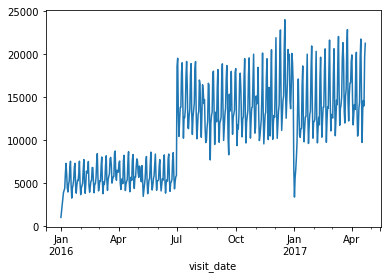

In [6]:
data_raw.groupby('visit_date').sum().visitors.plot()

The number of visitors per restaurant per night is right skewed.

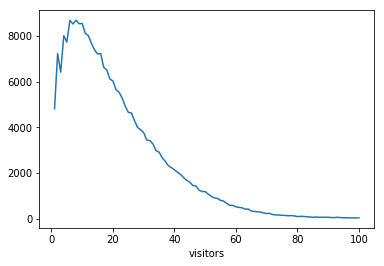

In [7]:
data_raw.groupby('visitors').count().visit_date.head(100).plot()

Taking the log of the target gives us a much more even distribution.

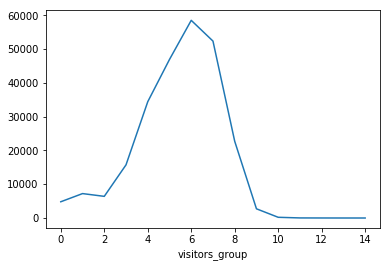

In [8]:
data_raw['visitors_group'] = round(np.log(data_raw.visitors)*2, 0)
data_raw.groupby('visitors_group').count().visit_date.plot()

Feather is a great way of landing data to disk.

In [9]:
os.makedirs('tmp', exist_ok=True)
data_raw.to_feather('tmp/recruit-raw')

In [10]:
data = pd.read_feather('tmp/recruit-raw')

Using fast.ai's add_datepart to pull out a bunch of useful information from the visit date.

In [11]:
train_cats(data)
add_datepart(data, 'visit_date')

Using fast.ai's proc_df to process the dataframe into something suitable for a Random Forest.

In [12]:
df, y, nas = proc_df(data, 'visitors_group')
y = y.astype('str')

Split the data into training and validation sets

In [13]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(data)-n_valid
raw_train, raw_valid = split_vals(data_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((240108, 19), (240108,), (12000, 19))

Build a quick Random Forest.

In [14]:
m = RandomForestClassifier(n_estimators=5, max_depth=3, max_features=0.5, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=3, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Extract the probabilities of each category.

In [15]:
results = m.predict_proba(df)
results_df = pd.DataFrame(data=results, columns=m.classes_)
results_df[1:5]

,0.0,1.0,10.0,11.0,12.0,13.0,14.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
1,0.003666,0.005825,0.000960,0.000132,0.000068,0.000014,0.0,0.005116,0.012742,0.028554,0.039778,0.049731,0.721875,0.119937,0.011602
2,0.002563,0.003819,0.001624,0.000176,0.000066,0.000013,0.0,0.003182,0.007858,0.019112,0.031224,0.046663,0.709562,0.153339,0.020799
3,0.012227,0.018633,0.000322,0.000032,0.000011,0.000002,0.0,0.016052,0.039777,0.093009,0.140817,0.593905,0.052651,0.028441,0.004120
4,0.026271,0.040726,0.000088,0.000014,0.000009,0.000002,0.0,0.035609,0.088413,0.201418,0.288993,0.263983,0.040387,0.013076,0.001012


Check the minimum and maximum likelihood of the most common category.

In [16]:
min(results_df['7.0']), max(results_df['7.0'])

(0.01530486827339283, 0.7218751602449296)

# Random Sort walkthrough

In this walkthrough we're looking to see if we can predict the total number of visitors at all restaurants (to keep things simple we'll leave the number of visitors as the log value calculated earlier). Our challenge is to also provide Probability of Exceedance (PoE) values - estimates that should be exceeded in a set percentage of cases (e.g. a PoE 90 should be exceeded 90% of the time and a PoE 10 should be exceeded 10% of the time).

The existing numpy.random.choice implementation doesn't support mulitple probabilities, the random_choice function below is based on this stack overflow post:

https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s

Using random_choice we sample 100 times from the distribution of possible outcomes.

In [17]:
def random_choice(results):
    c = results.cumsum(axis=1)
    u = np.random.rand(len(c), 1)
    choices = (u < c).argmax(axis=1)
    return m.classes_[choices].astype('float')

for i in range(100):
    data_raw['selected'+str(i)] = random_choice(results)
data_raw.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,visitors_group,selected0,selected1,selected2,selected3,selected4,selected5,selected6,selected7,selected8,selected9,selected10,selected11,selected12,selected13,selected14,selected15,selected16,selected17,selected18,selected19,selected20,selected21,selected22,selected23,selected24,selected25,selected26,selected27,selected28,selected29,selected30,selected31,selected32,selected33,selected34,selected35,selected36,selected37,selected38,selected39,selected40,selected41,selected42,selected43,selected44,selected45,selected46,selected47,selected48,selected49,selected50,selected51,selected52,selected53,selected54,selected55,selected56,selected57,selected58,selected59,selected60,selected61,selected62,selected63,selected64,selected65,selected66,selected67,selected68,selected69,selected70,selected71,selected72,selected73,selected74,selected75,selected76,selected77,selected78,selected79,selected80,selected81,selected82,selected83,selected84,selected85,selected86,selected87,selected88,selected89,selected90,selected91,selected92,selected93,selected94,selected95,selected96,selected97,selected98,selected99
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6.0,6.0,6.0,6.0,5.0,5.0,7.0,6.0,6.0,6.0,6.0,5.0,5.0,6.0,6.0,4.0,0.0,6.0,5.0,4.0,5.0,5.0,4.0,5.0,6.0,4.0,8.0,6.0,7.0,6.0,0.0,6.0,5.0,10.0,6.0,5.0,6.0,6.0,6.0,5.0,5.0,7.0,3.0,4.0,1.0,5.0,6.0,5.0,6.0,6.0,3.0,5.0,4.0,5.0,4.0,0.0,6.0,5.0,4.0,1.0,6.0,6.0,6.0,0.0,6.0,6.0,5.0,6.0,0.0,6.0,6.0,5.0,5.0,6.0,5.0,6.0,6.0,6.0,5.0,4.0,6.0,2.0,6.0,2.0,5.0,6.0,5.0,5.0,6.0,7.0,3.0,5.0,6.0,5.0,6.0,3.0,8.0,6.0,3.0,1.0,4.0
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,7.0,4.0,8.0,8.0,7.0,6.0,7.0,7.0,7.0,7.0,8.0,4.0,6.0,7.0,8.0,7.0,8.0,8.0,7.0,3.0,7.0,7.0,7.0,5.0,7.0,8.0,8.0,7.0,5.0,4.0,5.0,7.0,7.0,2.0,7.0,7.0,8.0,7.0,8.0,8.0,7.0,7.0,10.0,3.0,7.0,8.0,7.0,7.0,1.0,8.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,8.0,5.0,7.0,7.0,5.0,7.0,6.0,4.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,6.0,8.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,8.0,7.0,6.0,7.0,6.0,8.0,7.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,9.0,7.0,9.0,8.0,9.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,10.0,7.0,8.0,8.0,7.0,7.0,7.0,8.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,8.0,4.0,7.0,7.0,7.0,8.0,5.0,7.0,8.0,7.0,7.0,7.0,7.0,5.0,7.0,6.0,7.0,7.0,8.0,7.0,8.0,7.0,8.0,7.0,8.0,7.0,7.0,6.0,7.0,7.0,7.0,7.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6.0,6.0,6.0,6.0,6.0,5.0,6.0,2.0,3.0,6.0,6.0,5.0,8.0,5.0,6.0,6.0,6.0,4.0,6.0,4.0,6.0,4.0,6.0,6.0,6.0,5.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,4.0,6.0,1.0,6.0,5.0,6.0,5.0,6.0,6.0,4.0,3.0,6.0,8.0,6.0,6.0,4.0,5.0,5.0,6.0,6.0,5.0,6.0,4.0,6.0,6.0,6.0,6.0,5.0,6.0,5.0,4.0,4.0,6.0,6.0,4.0,6.0,6.0,7.0,6.0,7.0,4.0,4.0,7.0,6.0,5.0,6.0,6.0,6.0,6.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,7.0,6.0,6.0,6.0,6.0,0.0,5.0,6.0,8.0,6.0,7.0
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,4.0,5.0,6.0,4.0,6.0,7.0,4.0,6.0,6.0,5.0,5.0,5.0,6.0,5.0,3.0,6.0,5.0,4.0,6.0,4.0,6.0,3.0,4.0,3.0,5.0,3.0,3.0,3.0,6.0,3.0,6.0,6.0,4.0,3.0,7.0,3.0,6.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,6.0,4.0,5.0,6.0,6.0,5.0,5.0,6.0,4.0,6.0,5.0,5.0,6.0,6.0,6.0,6.0,1.0,5.0,5.0,1.0,6.0,1.0,5.0,5.0,4.0,4.0,5.0,6.0,4.0,4.0,8.0,7.0,5.0,8.0,4.0,6.0,4.0,6.0,5.0,5.0,2.0,3.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,6.0,5.0,6.0,3.0,5.0


If we compare the total of the selections to the actual number of visitors then it looks like the model is doing a reasonable job of predicting the total number of visitors.

In [18]:
data_summed = data_raw.groupby('visit_date').sum()
data_summed.head()

,visitors,latitude,longitude,visitors_group,selected0,selected1,selected2,selected3,selected4,selected5,selected6,selected7,selected8,selected9,selected10,selected11,selected12,selected13,selected14,selected15,selected16,selected17,selected18,selected19,selected20,selected21,selected22,selected23,selected24,selected25,selected26,selected27,selected28,selected29,selected30,selected31,selected32,selected33,selected34,selected35,selected36,selected37,selected38,selected39,selected40,selected41,selected42,selected43,selected44,selected45,selected46,selected47,selected48,selected49,selected50,selected51,selected52,selected53,selected54,selected55,selected56,selected57,selected58,selected59,selected60,selected61,selected62,selected63,selected64,selected65,selected66,selected67,selected68,selected69,selected70,selected71,selected72,selected73,selected74,selected75,selected76,selected77,selected78,selected79,selected80,selected81,selected82,selected83,selected84,selected85,selected86,selected87,selected88,selected89,selected90,selected91,selected92,selected93,selected94,selected95,selected96,selected97,selected98,selected99
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1033,1704.018603,6549.932636,241.0,275.0,257.0,254.0,270.0,259.0,255.0,270.0,260.0,254.0,253.0,271.0,249.0,271.0,260.0,266.0,269.0,268.0,259.0,264.0,257.0,267.0,251.0,296.0,237.0,259.0,256.0,255.0,276.0,273.0,269.0,273.0,252.0,256.0,262.0,247.0,244.0,268.0,268.0,276.0,269.0,265.0,256.0,256.0,255.0,242.0,279.0,268.0,274.0,241.0,257.0,266.0,274.0,264.0,260.0,273.0,263.0,260.0,263.0,265.0,265.0,268.0,257.0,252.0,264.0,252.0,274.0,269.0,233.0,249.0,262.0,239.0,264.0,266.0,254.0,268.0,274.0,244.0,258.0,269.0,281.0,280.0,277.0,257.0,274.0,258.0,281.0,249.0,236.0,250.0,265.0,265.0,260.0,272.0,231.0,281.0,266.0,241.0,249.0,266.0,282.0
2016-01-02,1764,2240.913705,8571.700192,374.0,375.0,380.0,366.0,375.0,373.0,364.0,342.0,364.0,369.0,353.0,392.0,364.0,358.0,350.0,375.0,360.0,363.0,362.0,379.0,361.0,389.0,387.0,378.0,353.0,373.0,362.0,362.0,371.0,360.0,342.0,365.0,357.0,365.0,378.0,371.0,344.0,368.0,375.0,361.0,371.0,372.0,366.0,370.0,360.0,379.0,372.0,350.0,366.0,371.0,363.0,362.0,378.0,349.0,373.0,355.0,353.0,366.0,371.0,367.0,364.0,354.0,369.0,375.0,367.0,372.0,372.0,364.0,368.0,376.0,366.0,373.0,374.0,377.0,384.0,360.0,357.0,356.0,372.0,389.0,381.0,366.0,355.0,373.0,362.0,362.0,355.0,356.0,362.0,385.0,369.0,365.0,382.0,376.0,387.0,373.0,353.0,375.0,367.0,354.0,359.0
2016-01-03,2368,2874.202294,11019.616645,487.0,450.0,472.0,455.0,449.0,471.0,501.0,455.0,472.0,450.0,489.0,474.0,474.0,467.0,478.0,442.0,470.0,494.0,464.0,463.0,463.0,479.0,487.0,490.0,473.0,460.0,483.0,459.0,492.0,454.0,470.0,460.0,478.0,481.0,467.0,498.0,475.0,475.0,457.0,492.0,466.0,495.0,496.0,502.0,485.0,475.0,462.0,493.0,485.0,473.0,471.0,482.0,458.0,456.0,472.0,483.0,485.0,474.0,484.0,484.0,501.0,495.0,439.0,473.0,490.0,475.0,468.0,457.0,460.0,462.0,462.0,472.0,468.0,498.0,482.0,475.0,476.0,476.0,469.0,490.0,478.0,479.0,499.0,459.0,483.0,476.0,488.0,478.0,474.0,486.0,482.0,469.0,463.0,475.0,456.0,469.0,462.0,460.0,487.0,454.0,462.0
2016-01-04,3326,5562.518351,21467.552403,863.0,852.0,864.0,837.0,833.0,843.0,834.0,834.0,841.0,842.0,835.0,818.0,825.0,835.0,846.0,849.0,823.0,859.0,818.0,821.0,816.0,857.0,854.0,846.0,824.0,883.0,826.0,841.0,831.0,826.0,830.0,847.0,815.0,849.0,812.0,831.0,817.0,809.0,836.0,814.0,839.0,854.0,860.0,837.0,866.0,888.0,846.0,846.0,817.0,835.0,820.0,845.0,855.0,803.0,871.0,860.0,834.0,864.0,840.0,812.0,853.0,800.0,866.0,858.0,828.0,824.0,840.0,841.0,809.0,850.0,853.0,823.0,852.0,811.0,815.0,809.0,824.0,847.0,833.0,842.0,834.0,820.0,816.0,833.0,836.0,837.0,846.0,848.0,843.0,809.0,873.0,820.0,827.0,837.0,796.0,822.0,846.0,807.0,839.0,790.0,817.0
2016-01-05,3927,8187.002391,31682.182033,1165.0,1103.0,1201.0,1165.0,1158.0,1175.0,1165.0,1200.0,1200.0,1178.0,1198.0,1139.0,1160.0,1163.0,1140.0,1204.0,1178.0,1176.

Use numpy's percentile function to calculate all of the PoE values.

In [19]:
data_transposed = data_summed.transpose()
for i in range(99):
    data_summed['poe'+str(99-i)] = np.percentile(np.array(data_transposed), i, axis=0)
data_summed.head()

,visitors,latitude,longitude,visitors_group,selected0,selected1,selected2,selected3,selected4,selected5,selected6,selected7,selected8,selected9,selected10,selected11,selected12,selected13,selected14,selected15,selected16,selected17,selected18,selected19,selected20,selected21,selected22,selected23,selected24,selected25,selected26,selected27,selected28,selected29,selected30,selected31,selected32,selected33,selected34,selected35,selected36,selected37,selected38,selected39,selected40,selected41,selected42,selected43,selected44,selected45,selected46,selected47,selected48,selected49,selected50,selected51,selected52,selected53,selected54,selected55,selected56,selected57,selected58,selected59,selected60,selected61,selected62,selected63,selected64,selected65,selected66,selected67,selected68,selected69,selected70,selected71,selected72,selected73,selected74,selected75,selected76,selected77,selected78,selected79,selected80,selected81,selected82,selected83,selected84,selected85,selected86,selected87,selected88,selected89,selected90,selected91,selected92,selected93,selected94,selected95,selected96,selected97,selected98,selected99,poe99,poe98,poe97,poe96,poe95,poe94,poe93,poe92,poe91,poe90,poe89,poe88,poe87,poe86,poe85,poe84,poe83,poe82,poe81,poe80,poe79,poe78,poe77,poe76,poe75,poe74,poe73,poe72,poe71,poe70,poe69,poe68,poe67,poe66,poe65,poe64,poe63,poe62,poe61,poe60,poe59,poe58,poe57,poe56,poe55,poe54,poe53,poe52,poe51,poe50,poe49,poe48,poe47,poe46,poe45,poe44,poe43,poe42,poe41,poe40,poe39,poe38,poe37,poe36,poe35,poe34,poe33,poe32,poe31,poe30,poe29,poe28,poe27,poe26,poe25,poe24,poe23,poe22,poe21,poe20,poe19,poe18,poe17,poe16,poe15,poe14,poe13,poe12,poe11,poe10,poe9,poe8,poe7,poe6,poe5,poe4,poe3,poe2,poe1
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1033,1704.018603,6549.932636,241.0,275.0,257.0,254.0,270.0,259.0,255.0,270.0,260.0,254.0,253.0,271.0,249.0,271.0,260.0,266.0,269.0,268.0,259.0,264.0,257.0,267.0,251.0,296.0,237.0,259.0,256.0,255.0,276.0,273.0,269.0,273.0,252.0,256.0,262.0,247.0,244.0,268.0,268.0,276.0,269.0,265.0,256.0,256.0,255.0,242.0,279.0,268.0,274.0,241.0,257.0,266.0,274.0,264.0,260.0,273.0,263.0,260.0,263.0,265.0,265.0,268.0,257.0,252.0,264.0,252.0,274.0,269.0,233.0,249.0,262.0,239.0,264.0,266.0,254.0,268.0,274.0,244.0,258.0,269.0,281.0,280.0,277.0,257.0,274.0,258.0,281.0,249.0,236.0,250.0,265.0,265.0,260.0,272.0,231.0,281.0,266.0,241.0,249.0,266.0,282.0,231.0,233.09,236.06,237.18,239.24,241.00,241.00,241.21,242.48,244.00,244.9,247.66,249.00,249.00,249.00,249.45,250.48,251.51,252.00,252.00,252.6,253.63,254.0,254.0,254.72,255.00,255.00,255.81,256.00,256.00,256.0,256.93,257.00,257.00,257.00,257.05,258.00,258.11,259.00,259.00,259.2,260.00,260.00,260.00,260.00,260.70,262.00,262.41,263.00,263.47,264.0,264.00,264.0,264.59,265.00,265.0,265.00,265.00,265.74,266.00,266.0,266.00,266.00,266.89,267.92,268.0,268.00,268.00,268.00,268.07,269.0,269.00,269.00,269.00,269.22,270.0,270.28,271.00,271.34,272.37,273.0,273.00,273.46,274.00,274.00,274.00,274.00,274.61,275.64,276.00,276.7,278.46,279.76,280.79,281.00,281.0,281.88,294.74,988.78
2016-01-02,1764,2240.913705,8571.700192,374.0,375.0,380.0,366.0,375.0,373.0,364.0,342.0,364.0,369.0,353.0,392.0,364.0,358.0,350.0,375.0,360.0,363.0,362.0,379.0,361.0,389.0,387.0,378.0,353.0,373.0,362.0,362.0,371.0,360.0,342.0,365.0,357.0,365.0,378.0,371.0,344.0,368.0,375.0,361.0,371.0,372.0,366.0,370.0,360.0,379.0,372.0,350.0,366.0,371.0,363.0,362.0,378.0,349.0,373.0,355.0,353.0,366.0,371.0,367.0,364.0,354.0,369.0,375.0,367.0,372.0,372.0,364.0,368.0,376.0,366.0,373.0,374.0,377.0,384.0,360.0,357.0,356.0,372.0,389.0,381.0,366.0,355.0,373.0,362.0,362.0,355.0,356.0,362.0,385.0,369.0,365.0,382.0,376.0,387.0,373.0,353.0,375.0,367.0,354.0,359.0,342.0,342.06,344.30,349.09,350.00,350.45,353.00,353.00,353.00,353.27,354.0,354.33,355.00,355.00,355

If we plot the PoE bands against the actuals then we can see that the actuals are going outside the PoE bands too often - the model is underestimating the variance.

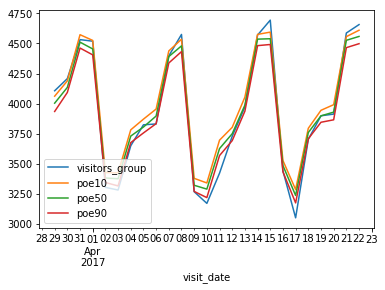

In [20]:
data_summed[['visitors_group','poe10','poe50','poe90']].tail(25).plot()

Check how often the PoE values are being exceeded by the actuals.

In [21]:
for i in range(99):
    data_summed['exceeded'+str(99-i)] = data_summed.visitors_group > data_summed['poe'+str(99-i)]
data_summed.head()

,visitors,latitude,longitude,visitors_group,selected0,selected1,selected2,selected3,selected4,selected5,selected6,selected7,selected8,selected9,selected10,selected11,selected12,selected13,selected14,selected15,selected16,selected17,selected18,selected19,selected20,selected21,selected22,selected23,selected24,selected25,selected26,selected27,selected28,selected29,selected30,selected31,selected32,selected33,selected34,selected35,selected36,selected37,selected38,selected39,selected40,selected41,selected42,selected43,selected44,selected45,selected46,selected47,selected48,selected49,selected50,selected51,selected52,selected53,selected54,selected55,selected56,selected57,selected58,selected59,selected60,selected61,selected62,selected63,selected64,selected65,selected66,selected67,selected68,selected69,selected70,selected71,selected72,selected73,selected74,selected75,selected76,selected77,selected78,selected79,selected80,selected81,selected82,selected83,selected84,selected85,selected86,selected87,selected88,selected89,selected90,selected91,selected92,selected93,selected94,selected95,selected96,selected97,selected98,selected99,poe99,poe98,poe97,poe96,poe95,poe94,poe93,poe92,poe91,poe90,poe89,poe88,poe87,poe86,poe85,poe84,poe83,poe82,poe81,poe80,poe79,poe78,poe77,poe76,poe75,poe74,poe73,poe72,poe71,poe70,poe69,poe68,poe67,poe66,poe65,poe64,poe63,poe62,poe61,poe60,poe59,poe58,poe57,poe56,poe55,poe54,poe53,poe52,poe51,poe50,poe49,poe48,poe47,poe46,poe45,poe44,poe43,poe42,poe41,poe40,poe39,poe38,poe37,poe36,poe35,poe34,poe33,poe32,poe31,poe30,poe29,poe28,poe27,poe26,poe25,poe24,poe23,poe22,poe21,poe20,poe19,poe18,poe17,poe16,poe15,poe14,poe13,poe12,poe11,poe10,poe9,poe8,poe7,poe6,poe5,poe4,poe3,poe2,poe1,exceeded99,exceeded98,exceeded97,exceeded96,exceeded95,exceeded94,exceeded93,exceeded92,exceeded91,exceeded90,exceeded89,exceeded88,exceeded87,exceeded86,exceeded85,exceeded84,exceeded83,exceeded82,exceeded81,exceeded80,exceeded79,exceeded78,exceeded77,exceeded76,exceeded75,exceeded74,exceeded73,exceeded72,exceeded71,exceeded70,exceeded69,exceeded68,exceeded67,exceeded66,exceeded65,exceeded64,exceeded63,exceeded62,exceeded61,exceeded60,exceeded59,exceeded58,exceeded57,exceeded56,exceeded55,exceeded54,exceeded53,exceeded52,exceeded51,exceeded50,exceeded49,exceeded48,exceeded47,exceeded46,exceeded45,exceeded44,exceeded43,exceeded42,exceeded41,exceeded40,exceeded39,exceeded38,exceeded37,exceeded36,exceeded35,exceeded34,exceeded33,exceeded32,exceeded31,exceeded30,exceeded29,exceeded28,exceeded27,exceeded26,exceeded25,exceeded24,exceeded23,exceeded22,exceeded21,exceeded20,exceeded19,exceeded18,exceeded17,exceeded16,exceeded15,exceeded14,exceeded13,exceeded12,exceeded11,exceeded10,exceeded9,exceeded8,exceeded7,exceeded6,exceeded5,exceeded4,exceeded3,exceeded2,exceeded1
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1033,1704.018603,6549.932636,241.0,275.0,257.0,254.0,270.0,259.0,255.0,270.0,260.0,254.0,253.0,271.0,249.0,271.0,260.0,266.0,269.0,268.0,259.0,264.0,257.0,267.0,251.0,296.0,237.0,259.0,256.0,255.0,276.0,273.0,269.0,273.0,252.0,256.0,262.0,247.0,244.0,268.0,268.0,276.0,269.0,265.0,256.0,256.0,255.0,242.0,279.0,268.0,274.0,241.0,257.0,266.0,274.0,264.0,260.0,273.0,263.0,260.0,263.0,265.0,265.0,268.0,257.0,252.0,264.0,252.0,274.0,269.0,233.0,249.0,262.0,239.0,264.0,266.0,254.0,268.0,274.0,244.0,258.0,269.0,281.0,280.0,277.0,257.0,274.0,258.0,281.0,249.0,236.0,250.0,265.0,265.0,260.0,272.0,231.0,281.0,266.0,241.0,249.0,266.0,282.0,231.0,233.09,236.06,237.18,239.24,241.00,241.00,241.21,242.48,244.00,244.9,247.66,249.00,249.00,249.00,249.45,250.48,251.51,252.00,252.00,252.6,253.63,254.0,254.0,254.72,255.00,255.00,255.81,256.00,256.00,256.0,256.93,257.00,257.00,257.00,257

This graph shows the actual percentage that each PoE value is exceeded (blue) against the percentage it should be (red).

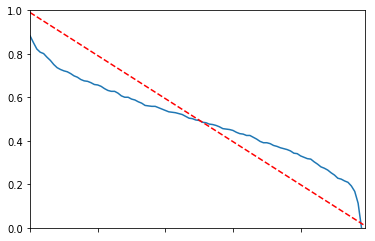

In [22]:
filter_col = [col for col in data_summed if col.startswith('exceeded')]
exceeded_mean = data_summed[filter_col].mean()
plot = exceeded_mean.plot()
plot.set(xlim=(0, 99), ylim=(0, 1))
diag_line, = plot.plot(plot.get_xlim(), (0.99,0.01), ls="--", color='red')

The important thing is that we can now measure the gap.

In [23]:
percent_variance = np.array(exceeded_mean) - np.flip(np.arange(0.01,1,0.01), axis=0)
percent_variance

array([-0.10715, -0.12854, -0.14782, -0.15247, -0.14874, -0.15548, -0.16013, -0.16895, -0.1736 , -0.17197,
       -0.16824, -0.16243, -0.16079, -0.16126, -0.15753, -0.15799, -0.15427, -0.14636, -0.14264, -0.141  ,
       -0.1331 , -0.12937, -0.12983, -0.1282 , -0.12238, -0.11238, -0.11075, -0.11331, -0.10958, -0.09958,
       -0.09795, -0.09213, -0.0905 , -0.08678, -0.08724, -0.07933, -0.07142, -0.06142, -0.0577 , -0.05397,
       -0.05025, -0.04653, -0.03862, -0.03071, -0.0249 , -0.01908, -0.01745, -0.01582, -0.00791, -0.00418,
        0.00372,  0.00536,  0.01326,  0.01699,  0.0249 ,  0.03071,  0.03444,  0.03607,  0.04397,  0.05188,
        0.0577 ,  0.05933,  0.06305,  0.07096,  0.07469,  0.08469,  0.08632,  0.08795,  0.08749,  0.09121,
        0.10121,  0.10703,  0.10866,  0.11448,  0.1182 ,  0.12402,  0.12983,  0.13356,  0.1331 ,  0.141  ,
        0.14054,  0.14427,  0.14799,  0.1559 ,  0.15335,  0.15289,  0.15033,  0.15406,  0.15569,  0.15314,
        0.15268,  0.14803,  0.15385, 

We're going to use the absolute value of the percent_variance that we've just calcuated as the threshold for sorting. 

To start we'll randomly select that many of each column.

In [24]:
percent_variance = abs(percent_variance)

def random_select(i):
    data_raw['random'] = np.random.rand(len(data_raw),1)
    data_raw['column'] = 'sort_selected'+str(i-1)
    data_raw['i'] = i
    return data_raw[data_raw.random < percent_variance[i-1]][['air_store_id', 'visit_date', 'column', 'i', 'selected'+str(i-1)]].rename(columns = {'selected'+str(i-1):'selected'})

data_sorted = random_select(1)
data_sorted = pd.concat([data_sorted, random_select(1)], axis=0)

for i in np.arange(2,100,1):
    data_sorted = pd.concat([data_sorted, random_select(i)], axis=0)
data_sorted.head()

,air_store_id,visit_date,column,i,selected
4,air_ba937bf13d40fb24,2016-01-18,sort_selected0,1,5.0
14,air_ba937bf13d40fb24,2016-01-29,sort_selected0,1,8.0
21,air_ba937bf13d40fb24,2016-02-09,sort_selected0,1,5.0
24,air_ba937bf13d40fb24,2016-02-12,sort_selected0,1,5.0
27,air_ba937bf13d40fb24,2016-02-16,sort_selected0,1,4.0


Have a quick look at the number of values selected for each column. It is a random sort, so the counts won't line up perfectly with the thresholds, but it should be plausible.

In [25]:
data_sorted.groupby('i').count().head()

,air_store_id,visit_date,column,selected
i,,,,
1,54185,54185,54185,54185
2,32677,32677,32677,32677
3,37083,37083,37083,37083
4,38595,38595,38595,38595
5,37770,37770,37770,37770


Sort the values for each air store id and visit date by the value selected.

In [26]:
data_sorted = data_sorted.sort_values(by=['air_store_id', 'visit_date', 'selected'], ascending=[True, True, False])
data_sorted.head(15)

,air_store_id,visit_date,column,i,selected
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected19,20,7.0
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected30,31,7.0
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected82,83,7.0
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected59,60,1.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected76,77,8.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected14,15,6.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected77,78,6.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected81,82,5.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected9,10,4.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected1,2,3.0


Then overwrite the column names in order (the i value shows the position the selected value initially had).

In [27]:
data_sorted['column'] = data_sorted.sort_values(by=['air_store_id', 'visit_date', 'i'])['column']
data_sorted.head(15)

,air_store_id,visit_date,column,i,selected
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected19,20,7.0
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected30,31,7.0
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected59,83,7.0
87534,air_00a91d42b08b08d9,2016-07-01,sort_selected82,60,1.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected1,77,8.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected8,15,6.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected9,78,6.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected14,82,5.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected18,10,4.0
87535,air_00a91d42b08b08d9,2016-07-02,sort_selected29,2,3.0


Pivoting the data makes it easier to join back in.

In [28]:
data_sorted_pivoted = data_sorted.pivot_table(index=['air_store_id','visit_date'], columns='column', values='selected')
data_sorted_pivoted.reset_index(inplace=True)  
data_sorted_pivoted.head()

column,air_store_id,visit_date,sort_selected0,sort_selected1,sort_selected10,sort_selected11,sort_selected12,sort_selected13,sort_selected14,sort_selected15,sort_selected16,sort_selected17,sort_selected18,sort_selected19,sort_selected2,sort_selected20,sort_selected21,sort_selected22,sort_selected23,sort_selected24,sort_selected25,sort_selected26,sort_selected27,sort_selected28,sort_selected29,sort_selected3,sort_selected30,sort_selected31,sort_selected32,sort_selected33,sort_selected34,sort_selected35,sort_selected36,sort_selected37,sort_selected38,sort_selected39,sort_selected4,sort_selected40,sort_selected41,sort_selected42,sort_selected43,sort_selected44,sort_selected45,sort_selected46,sort_selected47,sort_selected48,sort_selected49,sort_selected5,sort_selected50,sort_selected51,sort_selected52,sort_selected53,sort_selected54,sort_selected55,sort_selected56,sort_selected57,sort_selected58,sort_selected59,sort_selected6,sort_selected60,sort_selected61,sort_selected62,sort_selected63,sort_selected64,sort_selected65,sort_selected66,sort_selected67,sort_selected68,sort_selected69,sort_selected7,sort_selected70,sort_selected71,sort_selected72,sort_selected73,sort_selected74,sort_selected75,sort_selected76,sort_selected77,sort_selected78,sort_selected79,sort_selected8,sort_selected80,sort_selected81,sort_selected82,sort_selected83,sort_selected84,sort_selected85,sort_selected86,sort_selected87,sort_selected88,sort_selected89,sort_selected9,sort_selected90,sort_selected91,sort_selected92,sort_selected93,sort_selected94,sort_selected95,sort_selected96,sort_selected97,sort_selected98
0,air_00a91d42b08b08d9,2016-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,2016-07-02,NaN,8.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,6.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,2016-07-04,7.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,2016-07-05,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN
4,air_00a91d42b08b08d9,2016-07-06,NaN,NaN,NaN,9.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


Iterate through all of the selected columns and use the combine_first function to overwrite the value if it was sorted.

In [29]:
data_sorted_merged = pd.merge(data_raw, data_sorted_pivoted, how='left', on=['air_store_id', 'visit_date']) 
for i in range(99):
    data_sorted_merged['selected'+str(i)] = data_sorted_merged['sort_selected'+str(i)].combine_first(data_sorted_merged['selected'+str(i)])

cols = [c for c in data_sorted_merged.columns if c.lower()[:4] != 'sort']
data_sorted_merged=data_sorted_merged[cols]

data_sorted_merged.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,visitors_group,selected0,selected1,selected2,selected3,selected4,selected5,selected6,selected7,selected8,selected9,selected10,selected11,selected12,selected13,selected14,selected15,selected16,selected17,selected18,selected19,selected20,selected21,selected22,selected23,selected24,selected25,selected26,selected27,selected28,selected29,selected30,selected31,selected32,selected33,selected34,selected35,selected36,selected37,selected38,selected39,selected40,selected41,selected42,selected43,selected44,selected45,selected46,selected47,selected48,selected49,selected50,selected51,selected52,selected53,selected54,selected55,selected56,selected57,selected58,selected59,selected60,selected61,selected62,selected63,selected64,selected65,selected66,selected67,selected68,selected69,selected70,selected71,selected72,selected73,selected74,selected75,selected76,selected77,selected78,selected79,selected80,selected81,selected82,selected83,selected84,selected85,selected86,selected87,selected88,selected89,selected90,selected91,selected92,selected93,selected94,selected95,selected96,selected97,selected98,selected99,random,column,i
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6.0,6.0,6.0,6.0,5.0,5.0,7.0,6.0,6.0,6.0,6.0,5.0,5.0,8.0,6.0,4.0,0.0,8.0,5.0,4.0,5.0,5.0,4.0,5.0,6.0,4.0,6.0,6.0,7.0,6.0,0.0,6.0,6.0,10.0,6.0,5.0,6.0,6.0,6.0,5.0,5.0,7.0,3.0,4.0,1.0,5.0,6.0,5.0,6.0,6.0,3.0,5.0,4.0,5.0,4.0,0.0,6.0,5.0,4.0,1.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0,6.0,6.0,5.0,5.0,6.0,5.0,6.0,6.0,6.0,5.0,4.0,6.0,5.0,6.0,2.0,5.0,5.0,5.0,5.0,6.0,7.0,3.0,3.0,6.0,5.0,2.0,0.0,0.0,6.0,3.0,1.0,4.0,0.756947,sort_selected98,99
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,8.0,7.0,7.0,7.0,7.0,7.0,8.0,6.0,7.0,7.0,7.0,8.0,8.0,8.0,7.0,6.0,7.0,7.0,7.0,7.0,8.0,7.0,6.0,7.0,8.0,7.0,8.0,7.0,7.0,3.0,7.0,7.0,7.0,5.0,7.0,8.0,8.0,7.0,5.0,4.0,5.0,7.0,7.0,2.0,7.0,7.0,8.0,7.0,8.0,8.0,7.0,7.0,10.0,7.0,7.0,8.0,7.0,7.0,1.0,8.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,8.0,8.0,7.0,7.0,7.0,6.0,7.0,8.0,5.0,7.0,7.0,5.0,7.0,6.0,4.0,7.0,4.0,7.0,7.0,7.0,7.0,7.0,6.0,4.0,7.0,3.0,7.0,8.0,7.0,7.0,7.0,7.0,0.925711,sort_selected98,99
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.0,8.0,7.0,6.0,7.0,6.0,8.0,7.0,8.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,9.0,7.0,9.0,8.0,9.0,8.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,10.0,7.0,8.0,8.0,7.0,7.0,7.0,8.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,8.0,4.0,7.0,7.0,7.0,8.0,5.0,7.0,8.0,7.0,7.0,7.0,7.0,5.0,7.0,6.0,7.0,7.0,8.0,7.0,8.0,7.0,7.0,7.0,8.0,7.0,7.0,6.0,7.0,7.0,7.0,7.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,0.583403,sort_selected98,99
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6.0,6.0,6.0,6.0,6.0,5.0,6.0,2.0,3.0,6.0,6.0,6.0,8.0,5.0,6.0,6.0,6.0,6.0,6.0,4.0,6.0,4.0,6.0,6.0,6.0,5.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,4.0,6.0,1.0,6.0,5.0,6.0,5.0,6.0,6.0,4.0,3.0,6.0,8.0,6.0,6.0,4.0,5.0,5.0,6.0,6.0,5.0,6.0,4.0,6.0,6.0,6.0,6.0,5.0,6.0,5.0,4.0,4.0,6.0,6.0,4.0,6.0,6.0,7.0,6.0,7.0,4.0,4.0,7.0,6.0,6.0,6.0,6.0,6.0,6.0,4.0,5.0,6.0,5.0,6.0,6.0,4.0,7.0,6.0,6.0,4.0,6.0,0.0,5.0,6.0,8.0,6.0,7.0,0.264967,sort_selected98,99
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,4.0,6.0,6.0,4.0,6.0,7.0,4.0,6.0,6.0,6.0,5.0,5.0,6.0,5.0,6.0,6.0,5.0,4.0,5.0,4.0,6.0,3.0,4.0,3.0,5.0,3.0,3.0,5.0,6.0,5.0,6.0,6.0,4.0,3.0,7.0,3.0,6.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,6.0,4.0,5.0,6.0,6.0,5.0,5.0,6.0,4.0,6.0,5.0,5.0,6.0,6.0,6.0,4.0,1.0,5.0,4.0,1.0,6.0,1.0,5.0,5.0,3.0,4.0,5.0,6.0,4.0,4.0,8.0,7.0,5.0,8.0,4.0,6.0,4.0,6.0,5.0,5.0,2.0,3.0,4.0,5.0,4.0,4.0,3.0,5.0,4.0,4.0,4.0,3.0,5.0,6.0,3.0,5.0,0.175351,sort_selected98,99


Plot to the how the fit looks, much better than before.

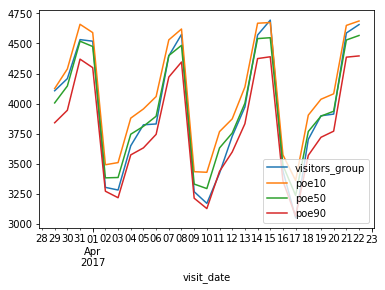

In [30]:
data_summed = data_sorted_merged.groupby('visit_date').sum()
data_transposed = data_summed.transpose()
for i in range(99):
    data_summed['poe'+str(99-i)] = np.percentile(np.array(data_transposed), i, axis=0)
data_summed[['visitors_group','poe10','poe50','poe90']].tail(25).plot()

Recalculate the exceeded values to check whether everything is lining up as it should.

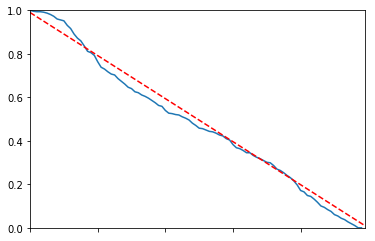

In [31]:
for i in range(99):
    data_summed['exceeded'+str(99-i)] = data_summed.visitors_group > data_summed['poe'+str(99-i)]
filter_col = [col for col in data_summed if col.startswith('exceeded')]
exceeded_mean = data_summed[filter_col].mean()
plot = exceeded_mean.plot()
plot.set(xlim=(0, 99), ylim=(0, 1))
diag_line, = plot.plot(plot.get_xlim(), (0.99,0.01), ls="--", color='red')

The randomness in the sorting means that the results change from run to run, but variance should be much better than before Random Sort was applied.